# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# descriptive statistics
df.groupby('email')['article_id'].count().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

Every user in the database interacts with at least one article (min: 1) and one-quarter of users only have got one interaction (25% quartile: 1). The median no. of interactions is three (50% quartile: 3) and three-quarters of users have nine interactions or less (75% quartile: 9). However, the arithmatic mean of the distribution is almost nine as well (mean: 8.931), indicating a positive skew. The users in the top quartile have more than nine interactions, and the most active user has 364 interaction (max: 364). 

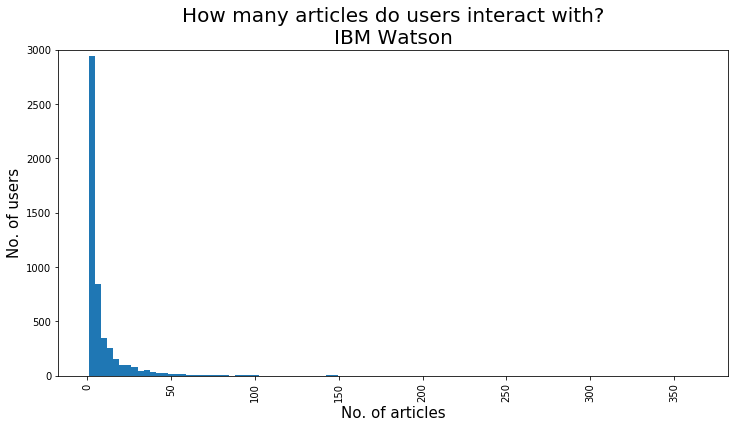

In [4]:
# Provide a visual 
x = df.groupby('email')['article_id'].count().values

# Let us print a histogram 
plt.figure(figsize=(12,6))
plt.title('How many articles do users interact with?\nIBM Watson',fontsize=20)
plt.hist(x, bins = 100)
plt.legend(loc= 'center left',fontsize=15)
plt.xlabel("No. of articles",fontsize=15)
plt.ylabel("No. of users",fontsize=15)
plt.ylim(0,3000)
plt.xticks(rotation='vertical')
plt.show();

The visual of the distribution shows a non-negative (positive) skewness. For a unimodal distribution, positive skew indicates that the tail is on the right. 

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles

ids = df_content["article_id"]
df_content[ids.isin(ids[ids.duplicated()])].sort_values(by=['article_id']) # list all rows with dublicate articles 
                                                                           # and sort by column "article_id"

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

# Let us verify that there are no dublicate articles left in df_content  
ids = df_content["article_id"]
df_content[ids.isin(ids[ids.duplicated()])].sort_values(by=['article_id']).shape[0] # No of  all rows with dublicate articles 
                                                                           

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

**a.** The number of unique articles that have an interaction with a user.  

In [8]:
# Let us see if there are missing article_id's in the user-item-interactions dataframe (i.e. article is not identified)
count_nan = df['article_id'].isnull().sum()
print ('Count of NaN: ' + str(count_nan))

Count of NaN: 0


In [9]:
# The number of unique articles that have an interaction with a user.

# Turn the column 'article-id' into a numpy series and convert the datatype of this array into a set. 
# By definition, sets consist only of unique entries.

                              
a                = len(set(df.article_id.values))

print(a)

714


**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>

In [10]:
# First, let us see if there are any missing fields in the data/articles_community dataframe df_content(i.e. NANs)

df_content1 = df_content[df_content.isna().any(axis=1)] # Display rows with one or more NaN values in df_content dataframe
df_content1

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765


There are a number of NANs in the columns **`doc_body`** and **`doc_description`**, but the column **`article_id`** looks complete. Therefore, we do not need to delete any rows due to missing data, because for every **`article_id`** there is an entry in the column **`doc_full_name`**. Furthermore, for every entry in **`article_id`** there is at least **`doc_body`** or **`doc_description`** provided. 

In [11]:
# Let us doubble check that there are no missing article_id's in the data/articles_community dataframe 
# (i.e. article is not identified)
count_nan = df_content['article_id'].isnull().sum()
print ('Count of NaN: ' + str(count_nan))

Count of NaN: 0


In [12]:
# The number of unique articles in the dataset (whether they have any interactions or not).

b = df_content['article_id'].nunique()

print(b)

1051


**c.** The number of unique users in the dataset. (excluding null values) <br>

In [13]:
# Let us see if there are missing emails in the user-item-interactions dataframe (i.e. user is not identified)
count_nan = df['email'].isnull().sum()
print('No of user-article interactions in the dataset (incl. NANs): ', df.shape[0])
print ('Count of NaN: ' + str(count_nan))


No of user-article interactions in the dataset (incl. NANs):  45993
Count of NaN: 17


In [14]:
df1 = df[df.isna().any(axis=1)] # Display rows with one or more NaN values in df dataframe
df1

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


There are a number of NANs in **df** (i.e. user-item-interactions dataframe), and all of the missing values appear in the column **`email`**. 

Let us create a new dataframe **df1** and remove all rows of **df** with mission values in the column **`email`**, because we cannot connect the **`article_id`** with a user. 

In [15]:
df1 = df[df['email'].notna()]#  take only the rows where 'email' is not NAN.

In [16]:
df1['email'].isnull().sum() # verify that there are no missing values left.

0

In [17]:
# The number of unique users in the dataset. (excluding null values) 

c = df1.email.unique().shape[0]

**d.** The number of user-article interactions in the dataset.

In [18]:
# The number of user-article interactions in the dataset.

d = df.shape[0]

print(d)

45993


In [19]:
unique_articles = a # The number of unique articles that have at least one interaction
total_articles = b # The number of unique articles on the IBM platform
unique_users = c # The number of unique users
user_article_interactions = d # The number of user-article interactions

`4.` Use the cells below to find the most viewed **`article_id`**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

Find the most viewed entry in column **`article_id`**.

In [20]:
# The most viewed article in the dataset as a string with one value following the decimal 
e = str(df.groupby('article_id')['email'].count().idxmax())

print(e)
print(type(e))

1429.0
<class 'str'>


How often was the most viewed entry in **`article_id`** viewed?

In [21]:
# The most viewed article in the dataset was viewed how many times?
f = df.groupby('article_id')['email'].count().max()

print(f)

937


Let us verify the result of the 'idxmax' method and the 'max' method by using an alternative method that works for both. 

In [22]:
# Show the top 5 acticles that were viewed most often by the users. 
df.groupby('article_id')['email'].count().sort_values(ascending=False).head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [23]:
most_viewed_article_id = e # The most viewed article in the dataset as a string with one value following the decimal 
max_views = f # The most viewed article in the dataset was viewed how many times?

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list(df.groupby('title')['user_id'].count().sort_values(ascending=False).head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list((df.groupby('article_id')['user_id'].count().sort_values(ascending=False).head(n).index.astype('str')))
 
    return top_articles # Return the top article ids


In [27]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [29]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    
    user_item = user_item.replace(np.nan,0).astype(int) # replace NANs with zeros for the entire DataFrame using NumPy
                                                        # and change datatype to integer
        
    user_item[user_item > 0] = 1                        # because all the columns are numeric, we can use boolean indexing
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [30]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [31]:
# Let us visualize the sparse dataframe 'user_item'
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
user_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 1 to 5149
Columns: 714 entries, 0.0 to 1444.0
dtypes: int64(714)
memory usage: 28.2 MB


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    inner_product = user_item[user_item.index == user_id].dot(user_item.T)

    # sort by similarity
    series1=inner_product.iloc[0,:] # create Pandas series by slicing 
    series1.sort_values(axis=0, ascending=False, inplace=True) # sort Pandas series 

    # create list of just the ids
    most_similar_users = list(series1.index) 
   
    # remove the own user's id
    most_similar_users.remove(user_id) 
                              
    return most_similar_users # return a list of the users in order from most to least similar
        

In [34]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
   
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values.tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    dataframe   = user_item.loc[user_id,:] # use slicing to get 1D dataframe 
    article_ids = dataframe[dataframe == 1].index.astype('str').tolist() # get a list of indices (i.e. article_ids) 
                                                                         # only from columns with values = 1
    
    article_names = get_article_names(article_ids) # call the function we've create before already 
                                                   # and pass the list of article_ids we've just created as an argument 
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    similar_users = find_similar_users(user_id) # returns a list of the users in order from most to least similar
    
    recs = set() # All elements in a set are unique.
    


    known_articles, _ = get_user_articles(user_id) # returns a list of articles the user already knows
    known_articles    = set(known_articles)        # turn the list into a set 

    for counter, user in enumerate(similar_users):
        
        user_articles, _ = get_user_articles(user)
        user_articles    = set(user_articles)
        
        new_recs  = user_articles.difference(known_articles) # find the difference between two sets
                                                             # It’ll return a new set containing elements 
                                                             # from set 'user_articles' not in set 'known_articles'
                
        recs      = recs.union(new_recs)                     # find the union of two sets
                                                             # It’ll return a new set containing elements from 
                                                             # set 'recs' and set 'new_recs'. But it won’t repeat elements. 
                                                             
        
        if len(recs) >= m:  # exit the loop if we have enough recommendations already
            break
            
    recs = list(recs)[:m] # turns set into a list with m elements                                                     
    
    return recs # return your recommendations for this user_id    

In [36]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['dsx: hybrid mode',
 'intents & examples for ibm watson conversation',
 'gosales transactions for logistic regression model',
 'optimizing a marketing campaign: moving from predictions to actions',
 'analyze precipitation data',
 'fertility rate by country in total births per woman',
 'awesome deep learning papers',
 'this week in data science (may 30, 2017)',
 'automating web analytics through python',
 'small steps to tensorflow']

In [37]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [38]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if any
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Create a new dataframe with one column  
    df1 = pd.DataFrame(columns=['neighbor_id'])

    # Call the function to find similar users and pass the user_id as an argument 
    df1['neighbor_id'] = find_similar_users(user_id, user_item)
    
    # Create a new dataframe and fill it with the inner products of each user with user_id
    df2 = (user_item[user_item.index == user_id].dot(user_item.T)).T
    
    # Pandas rename column by position 
    df2.rename(columns={ df2.columns[0]: "similarity" }, inplace = True) 
    
    df2.sort_values(by=['similarity'], ascending=False, inplace=True)
    
    # Inner join of df1 and df2
    df_inner = pd.merge(df1, df2, left_on='neighbor_id',right_on='user_id', how='inner')
    
    # user_id and how many articles they've interacted with
    df3 = df.groupby('user_id')['article_id'].count().sort_values(ascending=False).reset_index(name='num_interactions')
    
    # Inner join (SQL style) of 'df_inner' and 'df3' to create the final dataframe 'neighbors_df' 
    neighbors_df = pd.merge(df_inner, df3, left_on='neighbor_id',right_on='user_id', how='inner')
    
    # Remove the column 'user_id' from final dataframe 'neighbors_df', which is identical to column 'neighbor_id'
    neighbors_df.drop(['user_id'], axis=1, inplace=True)
    
    # Sort the final dataframe 'neighbors_df' by the similarity and then by number of interactions where 
    # highest of each is higher in the dataframe
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    recs = []
    
    forbidden_ids ,_     = get_user_articles(user_id, user_item)         # function returns tuple of the ids (list) 
                                                                         # and names (list), but we only need the first
        
    neighbors_df         = get_top_sorted_users(user_id, df, user_item)  # returns a dataframe 
    
    for user in neighbors_df['neighbor_id']:
        
        if len(recs) >= m:   # exit the loop if we have enough recommendations already
            break
            
        new_recs , _    =  get_user_articles(user, user_item) # Provides a list of the article_ids and article titles 
                                                              # that have been seen by a user
        
        # The second specification specifically mentions that if we have more recommendations from a similar user, 
        # we need to choose the articles with the most total interactions from these potential recommendations 
        # over articles with fewer interactions. 
        
        
        # We can use the get_top_articles function with a filtered dataframe (as the second argument) that contains only 
        # those articles that the current similar user has read.
        
        df_sorted       =  df[df.article_id.isin(new_recs)]   # select rows in user-item-interactions dataframe 
                                                              # whose column value is in the 'new_recs' list 
            
        number_new_recs =  len(new_recs)        
        
        new_recs_sorted =  get_top_article_ids(number_new_recs, df_sorted) # function returns a list of the top 'n' articles
        
        for article_id in new_recs_sorted:
            if article_id not in forbidden_ids:
                if len(recs) >= m:  # exit the loop if we have enough recommendations already
                    break
                else:
                    recs.append(article_id) # add the article_id to the list of recommendations 
                    
                    
    rec_names = get_article_names(recs)  # get the names of the article_id in the list of recommendations 
    
    
    
    return recs, rec_names

In [39]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [40]:
# Find the user that is most similar to user 1

df_user1   = get_top_sorted_users(1, df, user_item)
g          = df_user1.neighbor_id.loc[0]

print(g)

3933


In [41]:
# Find the 10th most similar user to user 131

df_user131  = get_top_sorted_users(131, df, user_item)
h           = df_user131.neighbor_id.loc[9]

print(h)

242


In [42]:
### Tests with a dictionary of results

user1_most_sim = g # Find the user that is most similar to user 1 
user131_10th_sim = h # Find the 10th most similar user to user 131

In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

A new user has not interacted with any article yet and we don not have other information about his/her preferences. In this case of a 'cold start problem', the popularity of an article can only be based on how often an article was interacted with by other users.

We would be able to make **Rank-Based Recommendations** for new users with this functions: 

    get_top_articles(n, df=df)
    get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
 
However, the Rank-Based Recommendations of this two functions are not tailored to the preferences of individual users, and they only reflect the preferences of the majority of users in the database.   
 
**Knowledge-based Recommendations** 

A better way to make recommendations to new users could use some prior knowledge about his/her preferences. We could ask some questions about fields of interest during the registration process. Next, we could recommend articles that meet the new user's specifications.      

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [44]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# My recommendations here
new_user_recs = get_top_article_ids(10, df) # Use Rank-Based Recommendations for new users 

articlesToShowToNewUsers = get_top_articles (n=10, df=df)
articlesToShowToNewUsers

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [45]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [46]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [47]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [48]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [49]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Let us get some information about user_item_matrix
user_item_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 1 to 5149
Columns: 714 entries, 0.0 to 997.0
dtypes: float64(714)
memory usage: 28.1 MB


In [51]:
# Let us look at the distribution of the variables (i.e. articles) in the dataframe.
user_item_matrix.describe()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
count,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,...,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000
mean,0.002331,0.001748,0.002136,0.001359,0.002719,0.002331,0.015343,0.020392,0.000971,0.011070,...,0.003302,0.024665,0.023305,0.000194,0.000777,0.002331,0.005050,0.003690,0.010099,0.000777
std,0.048224,0.041776,0.046176,0.036850,0.052078,0.048224,0.122924,0.141352,0.031150,0.104641,...,0.057370,0.155117,0.150887,0.013936,0.027864,0.048224,0.070887,0.060639,0.099995,0.027864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


***Finding:***
- The dataframe **user_item_matrix** is sparse with most elements being zero.

**Definition:** ***Sparsity of the matrix***

- The number of zero-valued elements divided by the total number of elements (e.g., m × n for an m × n matrix) is sometimes referred to as the **sparsity** of the matrix. (Source: Wikipedia)


Let us calculate the ***sparsity*** of the **user_item_matrix**. 

In [52]:
elements_total    = ( user_item_matrix.shape[0] * user_item_matrix.shape[1] ) # total number of elements 

non_zero_elements = user_item_matrix.astype(bool).sum(axis=0).sum() # count number of ones in dataframe

zero_elements     = elements_total - non_zero_elements

sparsity = (zero_elements / elements_total)
sparsity

0.99083828520726602

***Finding:*** 
- The dataframe **user_item_matrix** does not contain any NaN values.

In [53]:
user_item_matrix.isna().sum().sum() #  Count NaN values under an entire DataFrame

0

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [54]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Why can we successfully perform SVD on user_item_matrix**

In the lesson we have tried performing SVD on a matrix with missing values. However, even with just one NaN value we cannot perform SVD. In contrast, the **user_item_matrix** does not contain any NaN values despite being a sparse matrix with a sparsity of 99.1 percent.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

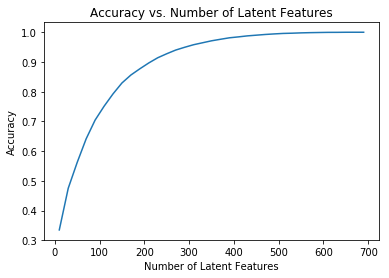

In [55]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [56]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train) # call the function from question 3 
                                                        # and pass the training dataframe as an argument
    
    user_item_test = create_user_item_matrix(df_test)   # call the function from question 3 
                                                        # and pass the test dataframe as an argument
        
    
    test_idx = user_item_test.index.tolist()            # get a list of all of the test user ids from the row index 
    
    test_arts = user_item_test.columns.astype('str').tolist() # get a list of column names (i.e. test article ids) 
                                                              # and make sure that each article_id is passed 
                                                              # to the lista string  
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [57]:
# How many users can we make predictions for in the test set?
# We can make predictions only on existing users (i.e. user_ids that appears in both the test set and the train set) 

answer1 = len(set(test_idx).intersection(set(user_item_train.index))) # The intersection of two or more sets 
                                                                      # is the set of elements that are common 
                                                                      # to all sets.
print(answer1)

20


In [58]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
# We cannot make predictions on new users (i.e. users in the test set but not in the train set) 
 
answer2 = len(set(test_idx).difference(set(user_item_train.index))) # returns the difference between two sets 
                                                                    # which is also a set.
print(answer2)

662


In [59]:
# How many articles can we make predictions for in the test set?
# We can make predictions only on existing articles (i.e. article_ids that appears in both the test set and the train set)

answer3 = len (set(test_arts).intersection(set(user_item_train.columns.astype('str'))))

print(answer3)

574


In [60]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?

answer4 = len(set(test_arts).difference(set(user_item_train.columns.astype('str')))) # returns the difference between 
                                                                                     # two sets

print(answer4)

0


In [61]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b, 
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d 
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [62]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [63]:
# Change the dimensions of u, s, and vt as necessary to use for the 20 users in the test set that SVD can make predictions on.
# Update the shape of u_train and store in u_new

# users in test set that can be predicted (because also in training set)
u_new = u_train[user_item_train.index.isin(test_idx), :] # We filter for test_idx - all of the test user ids

u_new.shape

(20, 4487)

In [64]:
# update the shape of s and store in s_new
s_new = np.zeros((len(s), len(s)))
s_new[:len(s), :len(s)] = np.diag(s) 

s_new.shape

(714, 714)

In [65]:
# user_ids in test set that can be predicted because also in the training set
vt_new = vt_train[:, user_item_train.columns.isin(test_arts)]

vt_new.shape#[1]

(714, 574)

In [66]:
u_new.shape, s_new.shape,  vt_new.shape

((20, 4487), (714, 714), (714, 574))

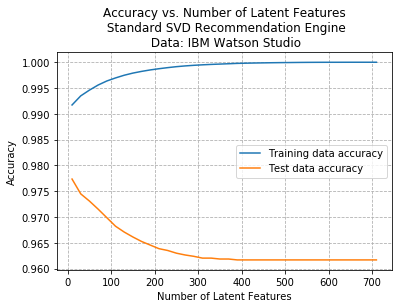

In [67]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feat=np.arange(10,714+10,20)

sum_errs_train = []
sum_errs_test  = []
intersec_ids   = list(set(user_item_train.index).intersection(set(test_idx))) # list of users in both train and test sets

for k in num_latent_feat: 
    # restructure with k latent features
    u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_lat, vt_test_lat = u_new[:, :k], vt_new[:k,:]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_est  = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test.loc[intersec_ids, :], user_item_test_est)
    
    # total errors and keep track of them 
    train_err = np.sum(np.sum(np.abs(diffs_train))) 
    sum_errs_train.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test))) 
    sum_errs_test.append(test_err)
    
    all_classifications_train = user_item_train_est.shape[0]* user_item_train_est.shape[1]
    all_classifications_test  = user_item_test_est.shape[0] * user_item_test_est.shape[1]
    
plt.plot(num_latent_feat, 1 - (np.array(sum_errs_train) / all_classifications_train), label='Training data accuracy')
plt.plot(num_latent_feat, 1 - (np.array(sum_errs_test ) / all_classifications_test),  label='Test data accuracy')
    

#plt.plot(num_latent_feat, 1 - (np.array(sum_errs_train)/(user_item_train_est.shape[0]* user_item_train_est.shape[1]))\
#         , label='Training data')
#plt.plot(num_latent_feat, 1 - (np.array(sum_errs_test )/(user_item_test_est.shape[0] * user_item_test_est.shape[1]))\
#         , label='Test data')

plt.grid(linestyle='--')
plt.title('Accuracy vs. Number of Latent Features\n Standard SVD Recommendation Engine\n Data: IBM Watson Studio')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.legend(loc='right')
plt.show();    

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles?


**My response here.**

We have performed a **Standard Singular Value Decomposition** (Standard SVD) matrix factorization technique to make article recommendations. We use real data from users on the IBM Watson Studio platform. We have used data on customers' interaction with articles on the platform to generate a User-Item Matrix (unique users for each row and unique articles for each column). However, the User-Item Matrix is a **sparse matrix** with 99.1 percent of elements being zero, indicating no interaction. The remaining .9 percent of elements are ones, indicating an interaction of a user with an article. We can perform Standard SVD because there are no missing values in User-Item Matrix. Even with just one missing value we cannot perform SVD. Alternatively, we could use Funk SVD to perform Matrix Factorization with missing values in the User-Item Matrix.

Next, we have divided the dataset into a training set and a test set to determine the optimal number of latent features for the SVD recommendation engine. **Based on the accuracy of the predictions on the training data and test data, we should choose about 100 latent features**. While the accuracy on the training data keeps improving from approx. 99.0 percent for 10 latent features with more latent features, the accuracy on the test data reaches its maximum of 97.5 percent with just 10 latent features and decreases with more latent features. However, we should take into consideration that the test data set is rather small, with only 20 users available for testing the model's predictions. Therefore, we should place more emphasis on the development of the accuracy of the training set, which starts to flatten above 100 latent features. 

However, **accuracy** is not a good metric to use here in this case, because it does not provide us with a fair assessment of the model's performance. Accuracy, the proportion of correct classifications among all classifications, may be **a poor measure for imbalanced data** like our sparse User-Item Matrix. Even without a model, we would achieve a high accuracy by simply predicting a zero value for every entry. Furthermore, the current assessment **framework is not robust enough to make conclusive results about the model**. The small number of only 20 users in our test set for whom we can make predictions is not sufficient.

Alternatively, we could use an online evaluation technique like **A/B testing** here. We could separate the user groups by userIDs, cookies, or IP addresses to get a 50:50 split. The users of the experimental group get article recommendations from our recommendation engine. The control group gets the current recommendations from IBM Watson. We would **track the number of articles the user interacts with during this experiment**. We could run the experiment until we get enough observations to achieve statistical power of 80 percent, 90 percent, or 95 percent. Statistical power is the probability of rejecting the null hypothesis (H0: recommendation engine has no impact on number of user-article interactions) given the true mean is different from the null (i.e., that the alternative hypothesis is true and that there is indeed a difference in the number of user-article interactions between the two recommendation engines). Increasing the number of observations will increase statistical power. Furthermore, we need to decide if we want to run a one-sided test (alternative hypothesis: our recommendation engine leads to higher user-article interaction) or two-sides test in case we want to check if our recommendation engine performs better or worse than the current one usede by IBM Watson.   



<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [68]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0